In [0]:
!wget https://github.com/MNRKhan/aps360-project/raw/master/modules/cleaning.py
!wget https://github.com/MNRKhan/aps360-project/raw/master/modules/data_loader.py
!wget https://github.com/MNRKhan/aps360-project/raw/master/modules/extractNet_connected.py
!wget https://github.com/MNRKhan/aps360-project/raw/master/modules/extractNet_connected_v2.py
!wget https://github.com/MNRKhan/aps360-project/raw/master/modules/extractNet_connected_vgg.py
!wget https://github.com/MNRKhan/aps360-project/raw/master/modules/extractNet_connected_vgg19.py
!wget https://github.com/MNRKhan/aps360-project/raw/master/modules/extractNet_simple.py
!wget https://github.com/MNRKhan/aps360-project/raw/master/modules/helper.py
!wget https://github.com/MNRKhan/aps360-project/raw/master/modules/metrics.py
!wget https://github.com/MNRKhan/aps360-project/raw/master/modules/trainer.py
!wget https://github.com/MNRKhan/aps360-project/raw/master/modules/visualizer.py

--2019-03-22 21:32:54--  https://github.com/MNRKhan/aps360-project/raw/master/modules/cleaning.py
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MNRKhan/aps360-project/master/modules/cleaning.py [following]
--2019-03-22 21:32:55--  https://raw.githubusercontent.com/MNRKhan/aps360-project/master/modules/cleaning.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8214 (8.0K) [text/plain]
Saving to: ‘cleaning.py’

cleaning.py         100%[===================>]   8.02K  --.-KB/s    in 0s      

2019-03-22 21:32:55 (96.7 MB/s) - ‘cleaning.py’ saved [8214/8214]

--2019-03-22 21:32:55--

In [0]:
import numpy as np
import os
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from helper import *
from cleaning import *
from visualizer import *
from metrics import *
from extractNet_simple import *
from extractNet_connected import *
from extractNet_connected_vgg19 import *
from trainer import *
from data_loader import *

In [0]:
!rm -rf __MACOSX
!rm -rf *.zip

In [0]:
!wget https://github.com/MNRKhan/aps360-project/raw/master/datasets/train2014/data_vehicle.zip

--2019-03-22 21:33:28--  https://github.com/MNRKhan/aps360-project/raw/master/datasets/val2017/data_super.zip
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MNRKhan/aps360-project/master/datasets/val2017/data_super.zip [following]
--2019-03-22 21:33:29--  https://raw.githubusercontent.com/MNRKhan/aps360-project/master/datasets/val2017/data_super.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9812038 (9.4M) [application/zip]
Saving to: ‘data_super.zip’

data_super.zip      100%[===================>]   9.36M  --.-KB/s    in 0.1s    

2019-03-22 21:33:29 (87.6 MB/s) - ‘data_sup

In [0]:
!rm -rf ./data
!unzip data_vehicle.zip

Archive:  data_super.zip
   creating: data/
   creating: data/images/
  inflating: data/images/63.jpg      
  inflating: data/images/189.jpg     
  inflating: data/images/77.jpg      
  inflating: data/images/638.jpg     
  inflating: data/images/604.jpg     
  inflating: data/images/162.jpg     
  inflating: data/images/176.jpg     
  inflating: data/images/88.jpg      
  inflating: data/images/610.jpg     
  inflating: data/images/348.jpg     
  inflating: data/images/360.jpg     
  inflating: data/images/406.jpg     
  inflating: data/images/412.jpg     
  inflating: data/images/374.jpg     
  inflating: data/images/599.jpg     
  inflating: data/images/228.jpg     
  inflating: data/images/214.jpg     
  inflating: data/images/572.jpg     
  inflating: data/images/566.jpg     
  inflating: data/images/200.jpg     
  inflating: data/images/758.jpg     
  inflating: data/images/770.jpg     
  inflating: data/images/764.jpg     
  inflating: data/images/765.jpg     
  inflating: data/

In [0]:
!rm -rf __MACOSX
!rm -rf *.zip

In [0]:
batch_size = 64
lr = 0.001

In [0]:
# Set random seeds

torch.manual_seed(360)
np.random.seed(360)
random.seed(360)

# Form dataset

transform = transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = ImageMaskDataset("/content/data", transform)

# Dataset sizes

size = len(dataset)
   
train_size = int(0.6 * size)
valid_size = int(0.2 * size)
test_size = size - train_size - valid_size

# Splitting datasets
  
train_data, valid_data, test_data = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])

# Making dataloader

train = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
valid = DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=0)

print("Size of dataset:", size)

Size of dataset: 776


In [0]:
# Empty cache

torch.cuda.empty_cache()

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = extractNet_connected_vgg19()
net.to(device)

print("Model is being trained on:", device)

Model is being trained on: cuda:0


In [0]:
trainModel(net, train, valid, batch_size=batch_size, lr=lr, num_epochs=50, checkpoint=False, device=device)

RuntimeError: ignored

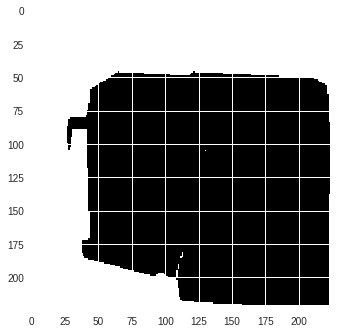

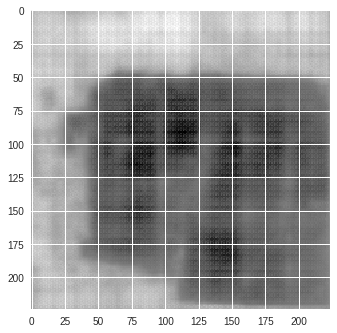

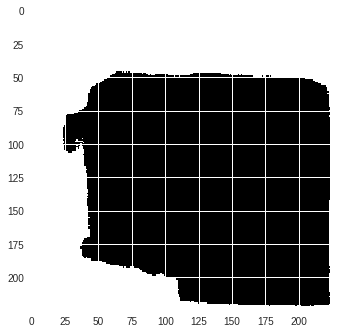

In [0]:
# After training

net.to("cpu")

img, target = train_data[0]

out = net(img.unsqueeze(0))
out = out.squeeze(0).squeeze(0).detach().numpy()

target = target.squeeze(0).detach().numpy()

plt.imshow(target)
plt.show()
plt.imshow(out)
plt.show()

result = torch.sigmoid(net(img.unsqueeze(0)))
result = thresholdProbMask(result.squeeze(0).squeeze(0).detach())

plt.imshow(result)
plt.show()